In [1]:
%pylab inline

import os
import sys
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cuda,floatX=float32,nvcc.flags=-arch=sm_35'
sys.path.append("/root")
sys.path.append("/home/peter")
sys.path.append("/home/peter/Desktop")
sys.path.append("/home/peter/Desktop/projects")
sys.path.append("/home/peter/Desktop/work")
sys.path.append("/home/peter/code/projects")
sys.path.append("/home/peter/code/work")
sys.path.append("/home/peter/code/common")

from ipywidgets import interact, interactive, fixed, IntSlider, FloatSlider
from IPython.display import clear_output, display, HTML

import cv2
import os
import pickle as pkl
from sklearn import linear_model
from sklearn.decomposition import PCA
import random as rnd
import numpy as np
import matplotlib.pyplot as plt

import theano.tensor as T
import theano as th

from keras.models import Sequential
from keras.layers.core import RepeatVector, Reshape, Permute, Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.convolutional import Convolution1D, MaxPooling1D, AveragePooling1D
from keras.layers.local import LocallyConnected1D
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.optimizers import SGD, Adadelta, Adamax, Adagrad, Adam, RMSprop, Nadam, TFOptimizer
from keras.callbacks import ModelCheckpoint

import cymysql as sql
import pandas as pd
import datetime 

Populating the interactive namespace from numpy and matplotlib


Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 950M (0000:01:00.0)
Using Theano backend.


In [2]:
from sklearn.preprocessing import scale

In [3]:
input_source = np.load(open('data_spy.npy','rb'))
tgt = np.load(open('data_spy_targets.npy','rb'))

In [4]:
to_predict = tgt[3]

In [5]:
winlen = 1

In [6]:
sliding_window_jump = 1
predict_time_ahead = 1

In [7]:
def get_partitioned_counts(cl, rr, rt):
    " data, steps_forward, partition_num"
    cl = cl[rr:] - cl[0:-rr]
    cl = hstack([[0]*rr, cl])
    pdown = len(cl[cl < -rt])
    pup = len(cl[cl > rt])
    pmid = len(cl[(cl <= rt) & (cl >= -rt)])
    return pup, pmid, pdown

In [8]:
def partition_data_num(cl, predict_ahead):
    a=[]
    b=[]
    c=[]
    ts = np.linspace(0.0, 1.0, 10000)
    for x in ts:
        au, am, ad = get_partitioned_counts(cl, predict_ahead, x)
        a.append(au)
        b.append(am)
        c.append(ad)
    a, b, c = array(a), array(b), array(c)
    return ts[np.argmin(np.abs(a-b) + np.abs(a-c) + np.abs(b-c))]

In [9]:
# create training set
sep = partition_data_num(to_predict, predict_time_ahead)

x = []
y = []

ups = []
downs = []
mids = []

for i in range(0, input_source.shape[1]-(winlen+100), sliding_window_jump):
    # form the input
    xs = input_source[:, i:i+winlen]
    #xs = scale(xs, axis=1)
    xs = xs.ravel()

    # for the output
    now = to_predict[i+winlen-1].ravel() # close
    future = to_predict[i+winlen+(predict_time_ahead-1)].ravel() # next close

    ys = future-now
    magn = abs(ys)

    if magn < sep:
        mids.append( (xs, np.array([0, 1, 0])) )
    else:
        if ys < 0:
            downs.append( (xs, np.array([0, 0, 1])) )
        else:
            ups.append( (xs, np.array([1, 0, 0])) )

    if (i%1000)==0:
        clear_output(wait=True)
        print('({}/{})'.format(i, input_source.shape[1]-winlen))

print('Ups: {0} Mids: {1} Downs: {2}'.format(len(ups), len(mids), len(downs)))
print('Separator: %3.5f' % sep)
print()

samplesize = min(len(ups), len(downs), len(mids))
s1 = rnd.sample(ups, samplesize)
s2 = rnd.sample(downs, samplesize)
s3 = rnd.sample(mids, samplesize)
a = s1 + s2 + s3
rnd.shuffle(a)
x = [x[0] for x in a]
y = [x[1] for x in a]

x = np.vstack(x)
y = np.vstack(y)

(277000/277890)
Ups: 100613 Mids: 77973 Downs: 99204
Separator: 0.01000



In [10]:
x.shape, y.shape

((233919, 172), (233919, 3))

In [11]:
x.shape = (x.shape[0], -1, winlen)

In [12]:
x.shape

(233919, 172, 1)

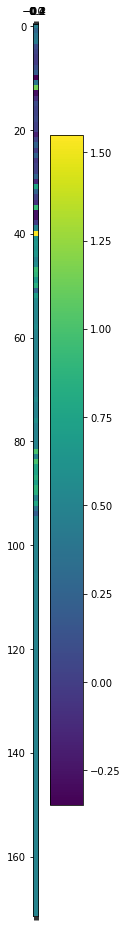

In [13]:
matshow(x[10]); colorbar();

In [14]:
cutpoint = int(0.8 * x.shape[0])
x_train = x[0:cutpoint]
x_test = x[cutpoint:]
y_train = y[0:cutpoint]
y_test = y[cutpoint:]

In [15]:
model = Sequential()


model.add(Flatten( input_shape=(x.shape[1], winlen) ))

model.add(Dense(80, init='uniform'))
model.add(Activation('relu'))

model.add(Dropout(0.8))

model.add(Dense(80, init='uniform'))
model.add(Activation('relu'))

model.add(Dropout(0.8))

model.add(Dense(40, init='uniform'))
model.add(Activation('tanh'))
    
model.add(Dropout(0.4))
    
model.add(Dense(3))
model.add(Activation('sigmoid'))

sgd = Adamax()#(lr=0.001, rho=0.9, epsilonAGE=1e-6)
model.compile(loss='mean_squared_logarithmic_error', optimizer=sgd,
              metrics=['accuracy']) 

In [16]:
pred = model.predict(x_test, batch_size=50)
corr = sum(argmax(pred, axis=1) == argmax(y_test, axis=1)) / pred.shape[0]
corr

0.33143809849521205

In [17]:
%%time

# training
###########
checkpointer = ModelCheckpoint(filepath="weights.nn", verbose=0, save_best_only=True)

history = model.fit(x_train, y_train, batch_size=500, nb_epoch=1000, verbose=2, 
                   validation_data = (x_test, y_test), callbacks = [checkpointer])

Train on 187135 samples, validate on 46784 samples
Epoch 1/1000
0s - loss: 0.1097 - acc: 0.3359 - val_loss: 0.1064 - val_acc: 0.3764
Epoch 2/1000
0s - loss: 0.1070 - acc: 0.3581 - val_loss: 0.1049 - val_acc: 0.4077
Epoch 3/1000
0s - loss: 0.1061 - acc: 0.3818 - val_loss: 0.1044 - val_acc: 0.4108
Epoch 4/1000
0s - loss: 0.1056 - acc: 0.3905 - val_loss: 0.1040 - val_acc: 0.4162
Epoch 5/1000
0s - loss: 0.1054 - acc: 0.3953 - val_loss: 0.1039 - val_acc: 0.4158
Epoch 6/1000
0s - loss: 0.1051 - acc: 0.4001 - val_loss: 0.1038 - val_acc: 0.4175
Epoch 7/1000
0s - loss: 0.1050 - acc: 0.4007 - val_loss: 0.1037 - val_acc: 0.4183
Epoch 8/1000
0s - loss: 0.1049 - acc: 0.4032 - val_loss: 0.1037 - val_acc: 0.4195
Epoch 9/1000
0s - loss: 0.1047 - acc: 0.4060 - val_loss: 0.1035 - val_acc: 0.4149
Epoch 10/1000
0s - loss: 0.1048 - acc: 0.4039 - val_loss: 0.1036 - val_acc: 0.4173
Epoch 11/1000
0s - loss: 0.1047 - acc: 0.4044 - val_loss: 0.1036 - val_acc: 0.4181
Epoch 12/1000
0s - loss: 0.1046 - acc: 0.4047

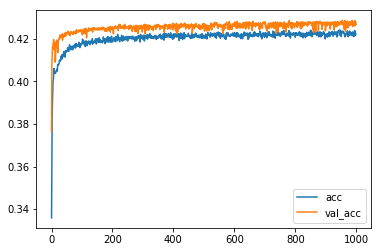

In [18]:
plot(history.history['acc'], label='acc');
plot(history.history['val_acc'], label='val_acc');
legend();